# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig0840s3"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 400

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1040, 32, 20, 3)
(1040, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Epoch 1/400


C:\Users\Muell\anaconda3\envs\py38-tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


260/260 [==============================] - 2s 4ms/step - loss: 2.1308 - accuracy: 0.3716
Epoch 2/400
260/260 [==============================] - 1s 4ms/step - loss: 1.4637 - accuracy: 0.5298
Epoch 3/400
260/260 [==============================] - 1s 5ms/step - loss: 1.0719 - accuracy: 0.6630
Epoch 4/400
260/260 [==============================] - 1s 5ms/step - loss: 0.9260 - accuracy: 0.7185
Epoch 5/400
260/260 [==============================] - 1s 5ms/step - loss: 0.7720 - accuracy: 0.7656
Epoch 6/400
260/260 [==============================] - 2s 6ms/step - loss: 0.6333 - accuracy: 0.7998
Epoch 7/400
260/260 [==============================] - 1s 6ms/step - loss: 0.5580 - accuracy: 0.8360
Epoch 8/400
260/260 [==============================] - 1s 5ms/step - loss: 0.5700 - accuracy: 0.8160: 0s - loss: 0.5794 - accuracy
Epoch 9/400
260/260 [==============================] - 1s 5ms/step - loss: 0.5126 - accuracy: 0.8418
Epoch 10/400
260/260 [==============================] - 1s 5ms/step - los

260/260 [==============================] - 2s 9ms/step - loss: 0.0709 - accuracy: 0.9893
Epoch 80/400
260/260 [==============================] - 3s 10ms/step - loss: 0.1104 - accuracy: 0.9680
Epoch 81/400
260/260 [==============================] - 2s 9ms/step - loss: 0.1556 - accuracy: 0.9615
Epoch 82/400
260/260 [==============================] - 2s 9ms/step - loss: 0.1079 - accuracy: 0.9634
Epoch 83/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0888 - accuracy: 0.9684
Epoch 84/400
260/260 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.97 - 2s 9ms/step - loss: 0.0876 - accuracy: 0.9785
Epoch 85/400
260/260 [==============================] - 2s 9ms/step - loss: 0.1067 - accuracy: 0.9741
Epoch 86/400
260/260 [==============================] - 2s 9ms/step - loss: 0.1084 - accuracy: 0.9711
Epoch 87/400
260/260 [==============================] - 3s 10ms/step - loss: 0.1631 - accuracy: 0.9573
Epoch 88/400
260/260 [=============================

260/260 [==============================] - 2s 9ms/step - loss: 0.0850 - accuracy: 0.9838
Epoch 157/400
260/260 [==============================] - 2s 9ms/step - loss: 0.1102 - accuracy: 0.9683
Epoch 158/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0504 - accuracy: 0.9865
Epoch 159/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0461 - accuracy: 0.9852
Epoch 160/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0399 - accuracy: 0.9904
Epoch 161/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0414 - accuracy: 0.9847
Epoch 162/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0592 - accuracy: 0.9867
Epoch 163/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0415 - accuracy: 0.9885
Epoch 164/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0790 - accuracy: 0.9789
Epoch 165/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0648 

260/260 [==============================] - 3s 10ms/step - loss: 0.0895 - accuracy: 0.9837
Epoch 235/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0506 - accuracy: 0.9801
Epoch 236/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0498 - accuracy: 0.9858
Epoch 237/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0567 - accuracy: 0.9846
Epoch 238/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0258 - accuracy: 0.9884
Epoch 239/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0486 - accuracy: 0.9849 0s - loss: 0.0492 - accuracy: 
Epoch 240/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0173 - accuracy: 0.9943: 0s - loss: 0.0164 - accuracy: 0.
Epoch 241/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0582 - accuracy: 0.9855
Epoch 242/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0436 - accuracy: 0.9920
Epoch 243/400
260

260/260 [==============================] - 2s 9ms/step - loss: 0.0255 - accuracy: 0.9928
Epoch 312/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0241 - accuracy: 0.9942
Epoch 313/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0535 - accuracy: 0.9871
Epoch 314/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0399 - accuracy: 0.9887
Epoch 315/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0446 - accuracy: 0.9872
Epoch 316/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0118 - accuracy: 0.9933
Epoch 317/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0557 - accuracy: 0.9840
Epoch 318/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0127 - accuracy: 0.9981
Epoch 319/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0240 - accuracy: 0.9936
Epoch 320/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0467 - 

260/260 [==============================] - 2s 9ms/step - loss: 0.0301 - accuracy: 0.9914
Epoch 390/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0196 - accuracy: 0.9912
Epoch 391/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0214 - accuracy: 0.9935
Epoch 392/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0393 - accuracy: 0.9890
Epoch 393/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0129 - accuracy: 0.9953
Epoch 394/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0393 - accuracy: 0.9895
Epoch 395/400
260/260 [==============================] - 2s 9ms/step - loss: 0.0178 - accuracy: 0.9942
Epoch 396/400
260/260 [==============================] - 2s 10ms/step - loss: 0.0273 - accuracy: 0.9947 0s - loss: 0.0271 - accura
Epoch 397/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0311 - accuracy: 0.9905 0s - loss: 0
Epoch 398/400
260/260 [====================

### Learing result
 
* Visualization of the training and validation results

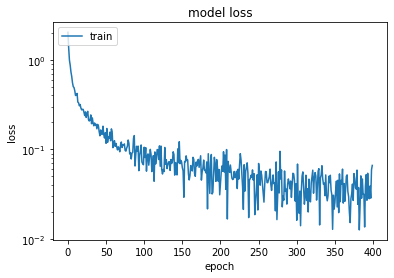

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

C:\Users\Muell\anaconda3\envs\py38-tf24\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


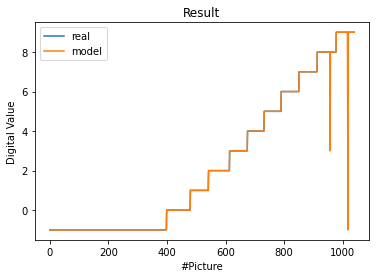

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpuyup1wwf\assets


219388

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp3168xzi_\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp3168xzi_\assets


63824

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


C:\Users\Muell\anaconda3\envs\py38-tf24\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ziffer_sortiert_resize/8\D8_2020-08-20_15-23-28.jpg 8 3
ziffer_sortiert_resize/9\D8_2020-08-16_01-02-52.jpg 9 3
ziffer_sortiert_resize/9\D8_2020-08-20_11-32-19.jpg 9 NaN


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.